<img src="./sf.png"  
     align="left"
     width="275" />
<img src="./crowd.jfif"
     align="right"
     width="400" />

# Fast AI - Happy or Angry Sports Crowds

I have recently started working through the `Practical Deep Learning for Coders` course developed by `fastai`. Fastai is an organization as well as a python library built on top of `pytorch`. Fastai was developed in large part by Jeremy Howard, President and Chief Scientist at Kaggle. 

This project is an adaptation of the example tutorial from the first chapter from the Practical Deep Learning course. The original tutorial created a deep learning classifier to identify bird photos vs forest photos. The course encourages learners to adapt the tutorial for novel purposes, so that is what I did in this notebook.


I decided to adapt the classifier to detect `happy vs. angry sports crowds`.

I got the idea for this sort of classifier several months before starting this course--in June of 2022. While visiting San Francisco, I went to a Giant's game with my sister's family. At the game, my brother-in-law asked me what are some potential applications of data science in sports. I wanted to think of some applications aside from the obvious goal of using player analytics to maximize performance. Aside from player analytics, there are many opportunities to optimize the business and marketing of sports using data. It's obvious that sports exist for entertainment... If fans did not show up to games or watch on TV, there would be no major league sports. `What are some ways to maximize fan enjoyment?`

Along those lines, I started thinking about what an MLB organization could do help make sure fans are enjoying the games. At another point that day, my brother-in-law mentioned that the music being played at the stadium heavily favored music from certain decades. He noticed a lot of 80's music being played at the game. My brother-in-law deducted that there is some sort of demographic analysis that influences their playlist choices--that the songs are chosen based on what the team's marketing department knows about the makeup of the crowd.

I thought his assessment seemed likely, however, there might be a more direct way to tell if the crowd enjoys the songs. An image classifier could be trained to recognize the emotion of a crowd. The model could be trained to recognize when a crowd seems to be happy/having fun, when a crowd is bored, when a crowd is angry, etc. 

*That's why I decided to try to build a proof of concept model that could detect the emotion of sports crowd images.*

In [1]:
# Check for connection to the internet
import socket,warnings
try:
    socket.setdefaulttimeout(1)
    socket.socket(socket.AF_INET, socket.SOCK_STREAM).connect(('1.1.1.1', 53))
except socket.error as ex: raise Exception("STOP: No internet. Click '>|' in top right and set 'Internet' switch to on")

In [4]:
### If running on Kaggle, uncomment this cell and comment the next cell ###
###########################################################################

# # Check for latest versions of packages. First check if on Kaggle, etc.
# import os
# iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

# if iskaggle:
#     !pip install -Uqq fastai duckduckgo_search

In [2]:
import os
!pip install -Uqq fastai duckduckgo_search

## Download images of Happy vs. Angry Crowds using Duckduckgo

In [3]:
from duckduckgo_search import ddg_images
from fastcore.all import *

def search_images(term, max_images=30):
    print(f"Searching for '{term}'")
    return L(ddg_images(term, max_results=max_images)).itemgot('image')

In [4]:
# `search_images` uses duckduckgo which sometimes returns incorrect results
# Might need to try again if there's a JSON error...
urls = search_images('Happy Sports Crowd Photo', max_images=1)
urls[0]

Searching for 'Happy Sports Crowd Photo'


'https://media.gettyimages.com/photos/crowd-of-happy-sport-fans-cheering-and-celebrating-picture-id490184588'

### Look at examples of happy vs angry sports crowds from the search results to make sure the results make sense.

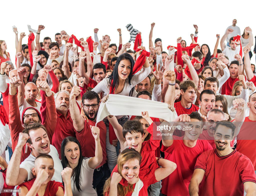

In [5]:
from fastdownload import download_url
dest = 'happy.jpg'
download_url(urls[0], dest, show_progress=False)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256)

Searching for 'Angry Sports Crowd Photo'


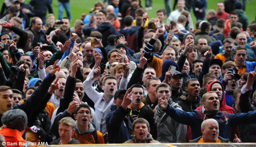

In [6]:
download_url(search_images('Angry Sports Crowd Photo', max_images=1)[0], 'angry.jpg', show_progress=False)
Image.open('angry.jpg').to_thumb(256,256)

In [7]:
# Try three varitions of search terms for each class.
searches = 'angry','happy'
path = Path('happy_or_angry')
from time import sleep

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} sports crowd photo'))
    sleep(10)  # Pause between searches to avoid over-loading server
    download_images(dest, urls=search_images(f'{o} stadium crowd photo'))
    sleep(10)
    download_images(dest, urls=search_images(f'{o} sports fans photo'))
    sleep(10)
    resize_images(path/o, max_size=400, dest=path/o)

Searching for 'angry sports crowd photo'
Searching for 'angry stadium crowd photo'
Searching for 'angry sports fans photo'
Searching for 'happy sports crowd photo'
Searching for 'happy stadium crowd photo'
Searching for 'happy sports fans photo'


In [11]:

# If images fail, remove them.
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

5

# Prepare the data to train the model
Create a pytorch `DataLoaders` object that containing a training and validation sets using the fastai's built-in `DataBlock` method.

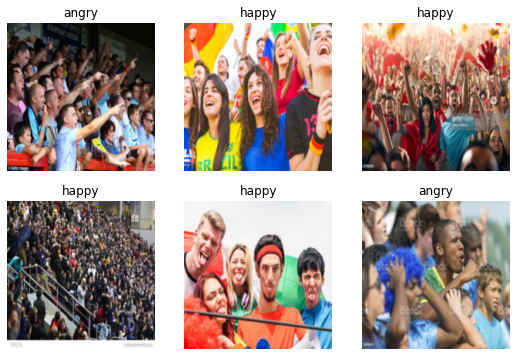

In [12]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), # define inputs and outputs -> images are inputs, outputs are categories.
    get_items=get_image_files, # get_image_files function returns a list of all image files in the path.
    splitter=RandomSplitter(valid_pct=0.2, seed=42), # Split into training and validation sets
    get_y=parent_label, # "y" labels here will be the name of the folder the images are placed in
    item_tfms=[Resize(192, method='squish')] # resize the image using the "squish" method rather than crop.
).dataloaders(path, bs=32)

dls.show_batch(max_n=6)

### Transfer learning is a way to use large, pre-trained deep learning models for related tasks.
    * You must use your own dataset to 'fine tune' the pre-trained model for your own task.

I use the `fine_tune()` function below to adapt the popular `resnet18` computer vision model to predict crowd emotions.

In [13]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time
0,1.339238,3.112350,0.484848,00:07


epoch,train_loss,valid_loss,error_rate,time
0,0.667593,0.840865,0.333333,00:01
1,0.615571,1.133442,0.484848,00:01
2,0.508287,1.188687,0.424242,00:01


Check how the model does using the example happy crowd image seen earlier.

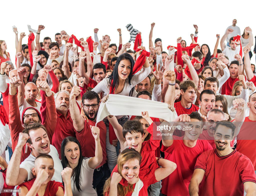

In [19]:
# Show the first example again
im = Image.open('happy.jpg')
im.to_thumb(256,256)

In [23]:
is_happy,_,probs = learn.predict(PILImage.create('happy.jpg'))
print(f"This crowd is: {is_happy}.")
print(f"Probability it's a happy sports crowd: {1- probs[0]:.4f}") # Use 1 - probs[0] to check for happy and probs[0] to check for angry

This crowd is: happy.
Probability it's a happy sports crowd: 0.9965


Check how the model does using the angry example.

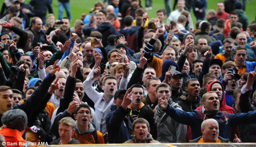

In [18]:
# angry image
Image.open('angry.jpg').to_thumb(256,256)

In [22]:

is_angry,_,probs = learn.predict(PILImage.create('angry.jpg'))
print(f"This crowd is: {is_angry}.")
print(f"Probability it's an angry sports crowd: {probs[0]:.4f}") # Use 1 - probs[0] to check for happy and probs[0] to check for angry

This crowd is: angry.
Probability it's an angry sports crowd: 0.9946


# Ideas for next steps
* Try other emotions or combinations of emotions.
    * Sad, anxious, bored, excited (bored vs excited is probably more relevant to the initial idea of maximizing entertainment)
    * Build a multiclass model predicting emotions using `Plutchik's wheel of emotions`.
      * More like sentiment analysis done with text.
* Find a way to get a more realistic dataset.
    * Maybe ask sports teams if they have or would be open to creating such a dataset.
        * Universities, sports business programs, or data science programs might be interested from a research perspective.
    * Try to simulate how this might work in production.
        * Expand dataset to include features relating to the song that's currently playing when a sample image is taken.
    * Expand beyond music use case to more (or all) events that take place during a game: Announcing player line ups, raffles or giveaways, veteran or community-focused events, etc.
    * If able to collect suitable data, conduct hypothesis tests.
        For example,
        * H<sub>0</sub>: The music played has no effect on crowds' enjoyment at sporting events.
        * H<sub>a</sub>: The music played significantly increases the crowds' enjoyment at sporting events.